In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
#Download Data from yahoo
stock='ACC'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

[*********************100%***********************]  1 of 1 completed


In [3]:
df=dfo.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3715 entries, 2007-01-02 to 2022-01-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3715 non-null   float64
 1   High       3715 non-null   float64
 2   Low        3715 non-null   float64
 3   Close      3715 non-null   float64
 4   Adj Close  3715 non-null   float64
 5   Volume     3715 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 203.2 KB


In [5]:
# #Validation
# df.isnull().any().any()
# nan_values=df[df.isnull().T.any()]
# nan_values

In [6]:
# To calculate sma[20,50]
def mv(sma,df,col):
    for sma in sma:
        df[f'{sma}{col}sma']=df[col].rolling(sma).mean().bfill()
    return df

In [7]:
def acc_dist(df):    
    df['mfm']=(2*(df['Close'])-df['Low']-df['High'])/(df['High']-df['Low'])
    #####actual formula#####
    #df['mfm']=((df['Close']-df['Low'])-(df['High']-df['Close']))/(df['High']-df['Low'])
    df['mfv']=df['mfm']*df['Volume']
    df['a/d']=df['mfm'].cumsum()
    df['a/d_v']=df['mfv'].cumsum()
    df.drop('mfm',axis=1,inplace=True)
    df.drop('mfv',axis=1,inplace=True)
    df.replace(to_replace=np.nan,value=0,inplace=True)
    
    return df

In [8]:
def wad(df):
    # TRH = Yesterday's close or today's high, whichever is greater
    # TRL = Yesterday's close or today's low, whichever is less.
    df['TRH']=np.where(df['High']>df['Close'].shift(1),df['High'],df['Close'].shift(1))
    df['TRL']=np.where(df['Low']<df['Close'].shift(1),df['Low'],df['Close'].shift(1))
    # If today's close is greater than yesterday's close:
    # Today's A/D = today's close - TRL
    # If today's close is less than yesterday's close:
    # Today's A/D = today's close - TRH
    # If today's close is equal to yesterday's close:
    # Today's A/D = 0
    #The Williams' Accumulation/Distribution indicator is a cummulative total of these daily values.
    #Williams' A/D = Today's A/D + Yesterday's Williams' A/D

    conditions=[(df['Close']>df['Close'].shift(1)),
                (df['Close']<df['Close'].shift(1)),
                (df['Close']==df['Close'].shift(1))]
    values=[(df['Close']-df['TRL']),(df['Close']-df['TRH']),(0)]
    df['tad']=np.select(conditions,values)
    df['wad']=df['tad'].cumsum()
    df.drop('TRH',axis=1,inplace=True)
    df.drop('TRL',axis=1,inplace=True)
    df.drop('tad',axis=1,inplace=True)
    df.replace(to_replace=np.nan,value=0,inplace=True)
    return df

In [9]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-01-02  1096.000000  1096.900024  1083.099976  1092.949951   804.138489   
2007-01-03  1080.000000  1104.400024  1067.000000  1073.599976   789.901550   
2007-01-04  1083.500000  1089.800049  1064.000000  1071.800049   788.577637   
2007-01-05  1080.000000  1080.000000  1045.099976  1054.699951   775.995972   
2007-01-08  1055.000000  1059.949951  1020.049988  1028.650024   756.829712   
...                 ...          ...          ...          ...          ...   
2022-01-19  2261.000000  2262.800049  2219.199951  2231.800049  2231.800049   
2022-01-20  2230.000000  2285.250000  2230.000000  2254.000000  2254.000000   
2022-01-21  2240.000000  2255.899902  2196.000000  2215.750000  2215.750000   
2022-01-24  2210.000000  2219.649902  2148.350098  2167.449951  2167.449951   
2022-01-25  2160.100098  2192.600098  2120.050049  2179.949951  2179.949951   

            Volume  
Date                
2007-01-02  261173  
2007-01-03  429012  
2007-01-04  448277  
2007-01-05  319430  
2007-01-08  311429  
...            ...  
2022-01-19  372235  
2022-01-20  322553  
2022-01-21  238038  
2022-01-24  467114  
2022-01-25  262179  

[3715 rows x 6 columns]

In [10]:
def hik(df):
    df['_Close']=(df['Open']+df['High']+df['Low']+df['Close'])/4
    df['_Open']=(df['Open'].shift(1)+df['Close'].shift(1))/2
    df['_High']=df[['High','Open','Close']].max(axis=1)
    df['_Low']=df[['Low','Open','Close']].min(axis=1)
    df.replace(to_replace=np.nan,method='bfill',inplace=True)
    return df

In [11]:
df=acc_dist(df)
df=wad(df)

In [12]:
df=hik(df)

In [13]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-01-02  1096.000000  1096.900024  1083.099976  1092.949951   804.138489   
2007-01-03  1080.000000  1104.400024  1067.000000  1073.599976   789.901550   
2007-01-04  1083.500000  1089.800049  1064.000000  1071.800049   788.577637   
2007-01-05  1080.000000  1080.000000  1045.099976  1054.699951   775.995972   
2007-01-08  1055.000000  1059.949951  1020.049988  1028.650024   756.829712   
...                 ...          ...          ...          ...          ...   
2022-01-19  2261.000000  2262.800049  2219.199951  2231.800049  2231.800049   
2022-01-20  2230.000000  2285.250000  2230.000000  2254.000000  2254.000000   
2022-01-21  2240.000000  2255.899902  2196.000000  2215.750000  2215.750000   
2022-01-24  2210.000000  2219.649902  2148.350098  2167.449951  2167.449951   
2022-01-25  2160.100098  2192.600098  2120.050049  2179.949951  2179.949951   

            Volume         a/d         a/d_v          wad       _Close  \
Date                                                                     
2007-01-02  261173    0.427528  1.116587e+05     0.000000  1092.237488   
2007-01-03  429012   -0.219533 -1.659380e+05   -30.800049  1081.250000   
2007-01-04  448277   -0.614879 -3.431626e+05   -48.800049  1077.275024   
2007-01-05  319430   -1.064737 -4.868609e+05   -74.100098  1064.949982   
2007-01-08  311429   -1.633658 -6.640391e+05  -105.400024  1040.912491   
...            ...         ...           ...          ...          ...   
2022-01-19  372235 -125.600414 -3.997414e+06 -2599.499481  2243.700012   
2022-01-20  322553 -125.731635 -4.039740e+06 -2575.499481  2249.812500   
2022-01-21  238038 -126.072202 -4.120808e+06 -2615.649384  2226.912476   
2022-01-24  467114 -126.536440 -4.337660e+06 -2667.849335  2186.362488   
2022-01-25  262179 -125.885169 -4.166910e+06 -2607.949432  2163.175049   

                  _Open        _High         _Low  
Date                                               
2007-01-02  1094.474976  1096.900024  1083.099976  
2007-01-03  1094.474976  1104.400024  1067.000000  
2007-01-04  1076.799988  1089.800049  1064.000000  
2007-01-05  1077.650024  1080.000000  1045.099976  
2007-01-08  1067.349976  1059.949951  1020.049988  
...                 ...          ...          ...  
2022-01-19  2322.125000  2262.800049  2219.199951  
2022-01-20  2246.400024  2285.250000  2230.000000  
2022-01-21  2242.000000  2255.899902  2196.000000  
2022-01-24  2227.875000  2219.649902  2148.350098  
2022-01-25  2188.724976  2192.600098  2120.050049  

[3715 rows x 13 columns]

In [14]:
# As a formula, the equation for the disparity index would be expressed as:
# Disparity Index =  (Current Market Price − n-PMAV)/n-PMAV × 100
# where:
# n-PMAV=n-Period moving average value
def madisparity(df,ma,field):
    # df[field+'_di']=(df[field]-df[field].rolling(ma).mean())/df[field].rolling(ma).mean()*100
    df[str(ma)+field+'_di']=((df[field]-df[field].rolling(ma).mean())/df[field].rolling(ma).mean())*100
    df.replace(to_replace=np.nan,method='bfill',inplace=True)
    return df

In [15]:
################to check how much asset move up and down from given Moving average on field #############
malist=[250,125,63,31,21]
# ma=250
field='Close'
for ma in malist:
    df=madisparity(df,ma,field)



In [16]:
# malist=[]
# ma=50
# field='wad'
# df=madisparity(df,ma,field)


In [17]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-01-02  1096.000000  1096.900024  1083.099976  1092.949951   804.138489   
2007-01-03  1080.000000  1104.400024  1067.000000  1073.599976   789.901550   
2007-01-04  1083.500000  1089.800049  1064.000000  1071.800049   788.577637   
2007-01-05  1080.000000  1080.000000  1045.099976  1054.699951   775.995972   
2007-01-08  1055.000000  1059.949951  1020.049988  1028.650024   756.829712   
...                 ...          ...          ...          ...          ...   
2022-01-19  2261.000000  2262.800049  2219.199951  2231.800049  2231.800049   
2022-01-20  2230.000000  2285.250000  2230.000000  2254.000000  2254.000000   
2022-01-21  2240.000000  2255.899902  2196.000000  2215.750000  2215.750000   
2022-01-24  2210.000000  2219.649902  2148.350098  2167.449951  2167.449951   
2022-01-25  2160.100098  2192.600098  2120.050049  2179.949951  2179.949951   

            Volume         a/d         a/d_v          wad       _Close  \
Date                                                                     
2007-01-02  261173    0.427528  1.116587e+05     0.000000  1092.237488   
2007-01-03  429012   -0.219533 -1.659380e+05   -30.800049  1081.250000   
2007-01-04  448277   -0.614879 -3.431626e+05   -48.800049  1077.275024   
2007-01-05  319430   -1.064737 -4.868609e+05   -74.100098  1064.949982   
2007-01-08  311429   -1.633658 -6.640391e+05  -105.400024  1040.912491   
...            ...         ...           ...          ...          ...   
2022-01-19  372235 -125.600414 -3.997414e+06 -2599.499481  2243.700012   
2022-01-20  322553 -125.731635 -4.039740e+06 -2575.499481  2249.812500   
2022-01-21  238038 -126.072202 -4.120808e+06 -2615.649384  2226.912476   
2022-01-24  467114 -126.536440 -4.337660e+06 -2667.849335  2186.362488   
2022-01-25  262179 -125.885169 -4.166910e+06 -2607.949432  2163.175049   

                  _Open        _High         _Low  250Close_di  125Close_di  \
Date                                                                          
2007-01-02  1094.474976  1096.900024  1083.099976     4.320641    15.401519   
2007-01-03  1094.474976  1104.400024  1067.000000     4.320641    15.401519   
2007-01-04  1076.799988  1089.800049  1064.000000     4.320641    15.401519   
2007-01-05  1077.650024  1080.000000  1045.099976     4.320641    15.401519   
2007-01-08  1067.349976  1059.949951  1020.049988     4.320641    15.401519   
...                 ...          ...          ...          ...          ...   
2022-01-19  2322.125000  2262.800049  2219.199951     5.925609    -3.937667   
2022-01-20  2246.400024  2285.250000  2230.000000     6.867168    -2.970013   
2022-01-21  2242.000000  2255.899902  2196.000000     4.953462    -4.576570   
2022-01-24  2227.875000  2219.649902  2148.350098     2.576737    -6.591731   
2022-01-25  2188.724976  2192.600098  2120.050049     3.067986    -5.990884   

            63Close_di  31Close_di  21Close_di  
Date                                            
2007-01-02  -23.295200   -3.341231   -2.496194  
2007-01-03  -23.295200   -3.341231   -2.496194  
2007-01-04  -23.295200   -3.341231   -2.496194  
2007-01-05  -23.295200   -3.341231   -2.496194  
2007-01-08  -23.295200   -3.341231   -2.496194  
...                ...         ...         ...  
2022-01-19   -3.237573   -0.479506   -0.182944  
2022-01-20   -2.286935    0.565767    0.586937  
2022-01-21   -3.947555   -0.992265   -1.256294  
2022-01-24   -6.014840   -2.943297   -3.493546  
2022-01-25   -5.436137   -2.219573   -3.025905  

[3715 rows x 18 columns]

In [18]:
# df['5maStrength']=(2.2*df['250Close_di']+1.2*df['125Close_di']+.75*df['63Close_di']+.60*df['31Close_di']+.25*df['21Close_di'])/5
df['5maStrengthop']=(2.2*df['21Close_di']+1.2*df['31Close_di']+.75*df['63Close_di']+.60*df['125Close_di']+.25*df['250Close_di'])/5
df['w_di_all_in_one']=(250*df['250Close_di']+125*df['125Close_di']+63*df['63Close_di']+31*df['31Close_di']+21*df['21Close_di'])/(250+125+63+31+21) # This is to use
df['0']=0
df['1']=1
df['-1']=-1
df['-5']=-5
df['-10']=-10
df['-20']=-20


In [19]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-01-02  1096.000000  1096.900024  1083.099976  1092.949951   804.138489   
2007-01-03  1080.000000  1104.400024  1067.000000  1073.599976   789.901550   
2007-01-04  1083.500000  1089.800049  1064.000000  1071.800049   788.577637   
2007-01-05  1080.000000  1080.000000  1045.099976  1054.699951   775.995972   
2007-01-08  1055.000000  1059.949951  1020.049988  1028.650024   756.829712   
...                 ...          ...          ...          ...          ...   
2022-01-19  2261.000000  2262.800049  2219.199951  2231.800049  2231.800049   
2022-01-20  2230.000000  2285.250000  2230.000000  2254.000000  2254.000000   
2022-01-21  2240.000000  2255.899902  2196.000000  2215.750000  2215.750000   
2022-01-24  2210.000000  2219.649902  2148.350098  2167.449951  2167.449951   
2022-01-25  2160.100098  2192.600098  2120.050049  2179.949951  2179.949951   

            Volume         a/d         a/d_v          wad       _Close  ...  \
Date                                                                    ...   
2007-01-02  261173    0.427528  1.116587e+05     0.000000  1092.237488  ...   
2007-01-03  429012   -0.219533 -1.659380e+05   -30.800049  1081.250000  ...   
2007-01-04  448277   -0.614879 -3.431626e+05   -48.800049  1077.275024  ...   
2007-01-05  319430   -1.064737 -4.868609e+05   -74.100098  1064.949982  ...   
2007-01-08  311429   -1.633658 -6.640391e+05  -105.400024  1040.912491  ...   
...            ...         ...           ...          ...          ...  ...   
2022-01-19  372235 -125.600414 -3.997414e+06 -2599.499481  2243.700012  ...   
2022-01-20  322553 -125.731635 -4.039740e+06 -2575.499481  2249.812500  ...   
2022-01-21  238038 -126.072202 -4.120808e+06 -2615.649384  2226.912476  ...   
2022-01-24  467114 -126.536440 -4.337660e+06 -2667.849335  2186.362488  ...   
2022-01-25  262179 -125.885169 -4.166910e+06 -2607.949432  2163.175049  ...   

            31Close_di  21Close_di  5maStrengthop  w_di_all_in_one  0  1  -1  \
Date                                                                           
2007-01-02   -3.341231   -2.496194      -3.330287         2.819906  0  1  -1   
2007-01-03   -3.341231   -2.496194      -3.330287         2.819906  0  1  -1   
2007-01-04   -3.341231   -2.496194      -3.330287         2.819906  0  1  -1   
2007-01-05   -3.341231   -2.496194      -3.330287         2.819906  0  1  -1   
2007-01-08   -3.341231   -2.496194      -3.330287         2.819906  0  1  -1   
...                ...         ...            ...              ... .. ..  ..   
2022-01-19   -0.479506   -0.182944      -0.857452         1.564327  0  1  -1   
2022-01-20    0.565767    0.586937       0.037953         2.512914  0  1  -1   
2022-01-21   -0.992265   -1.256294      -1.684561         0.735625  0  1  -1   
2022-01-24   -2.943297   -3.493546      -3.807948        -1.476171  0  1  -1   
2022-01-25   -2.219573   -3.025905      -3.245023        -0.932023  0  1  -1   

            -5  -10  -20  
Date                      
2007-01-02  -5  -10  -20  
2007-01-03  -5  -10  -20  
2007-01-04  -5  -10  -20  
2007-01-05  -5  -10  -20  
2007-01-08  -5  -10  -20  
...         ..  ...  ...  
2022-01-19  -5  -10  -20  
2022-01-20  -5  -10  -20  
2022-01-21  -5  -10  -20  
2022-01-24  -5  -10  -20  
2022-01-25  -5  -10  -20  

[3715 rows x 26 columns]

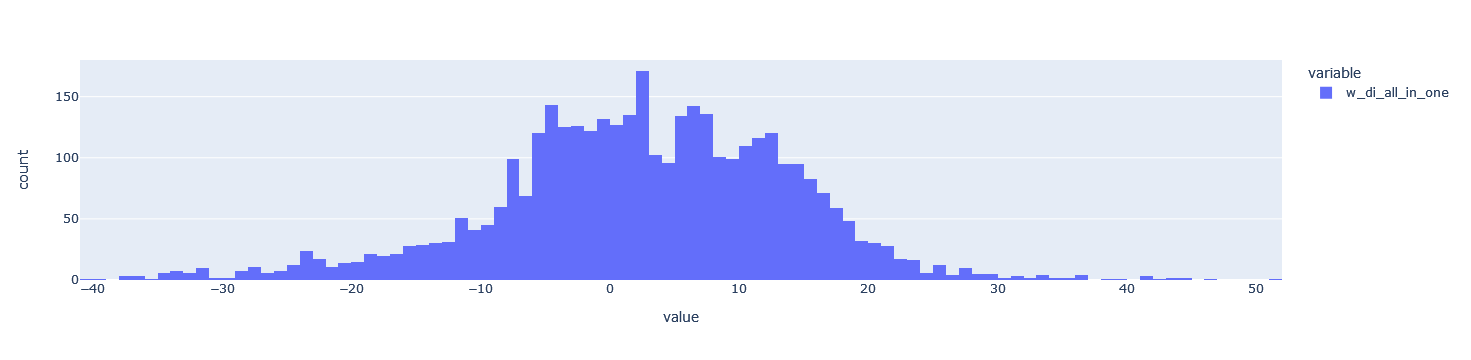

In [20]:
fig = px.histogram(df['w_di_all_in_one'],nbins=100)
fig.show()

In [21]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas.plotting._matplotlib.style import get_standard_colors

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = get_standard_colors(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])
        
        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

<AxesSubplot:xlabel='Date', ylabel='Close'>

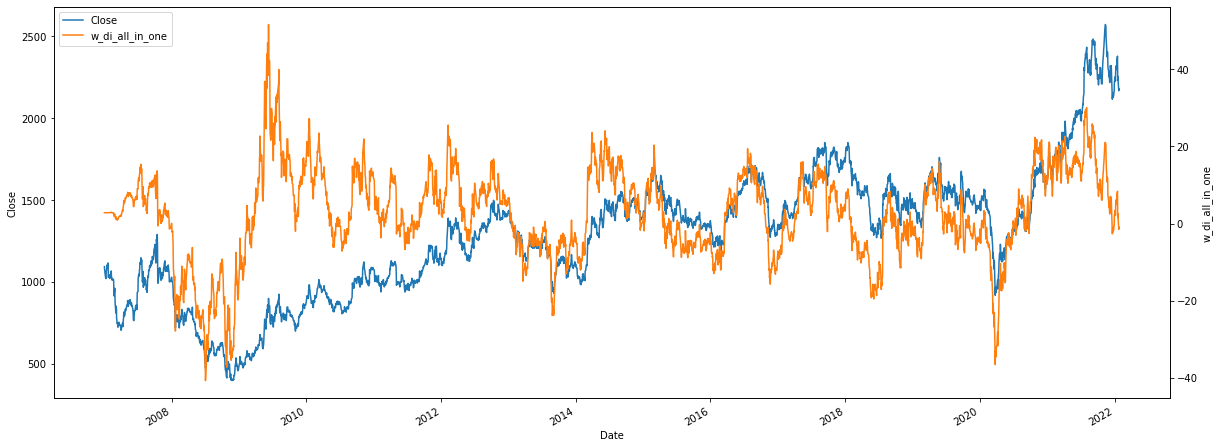

In [22]:
data =df[['Close','w_di_all_in_one',]]
plot_multi(data, figsize=(20, 8))

In [23]:
df['di_b_zero']=np.where(df['w_di_all_in_one']<0,df['w_di_all_in_one'],0)

In [24]:
# df[['w_di_all_in_one','di_b_zero']]
df['di_low_avg250']=df['di_b_zero'].rolling(250).mean()
df['di_low_avg50']=df['di_b_zero'].rolling(50).mean()

In [25]:
df['wdi_r1']=df['w_di_all_in_one'].rolling(125).max()
df['wdi_r2']=df['w_di_all_in_one'].rolling(250).max()
df['wdi_s2']=df['w_di_all_in_one'].rolling(250).min()

<AxesSubplot:xlabel='Date'>

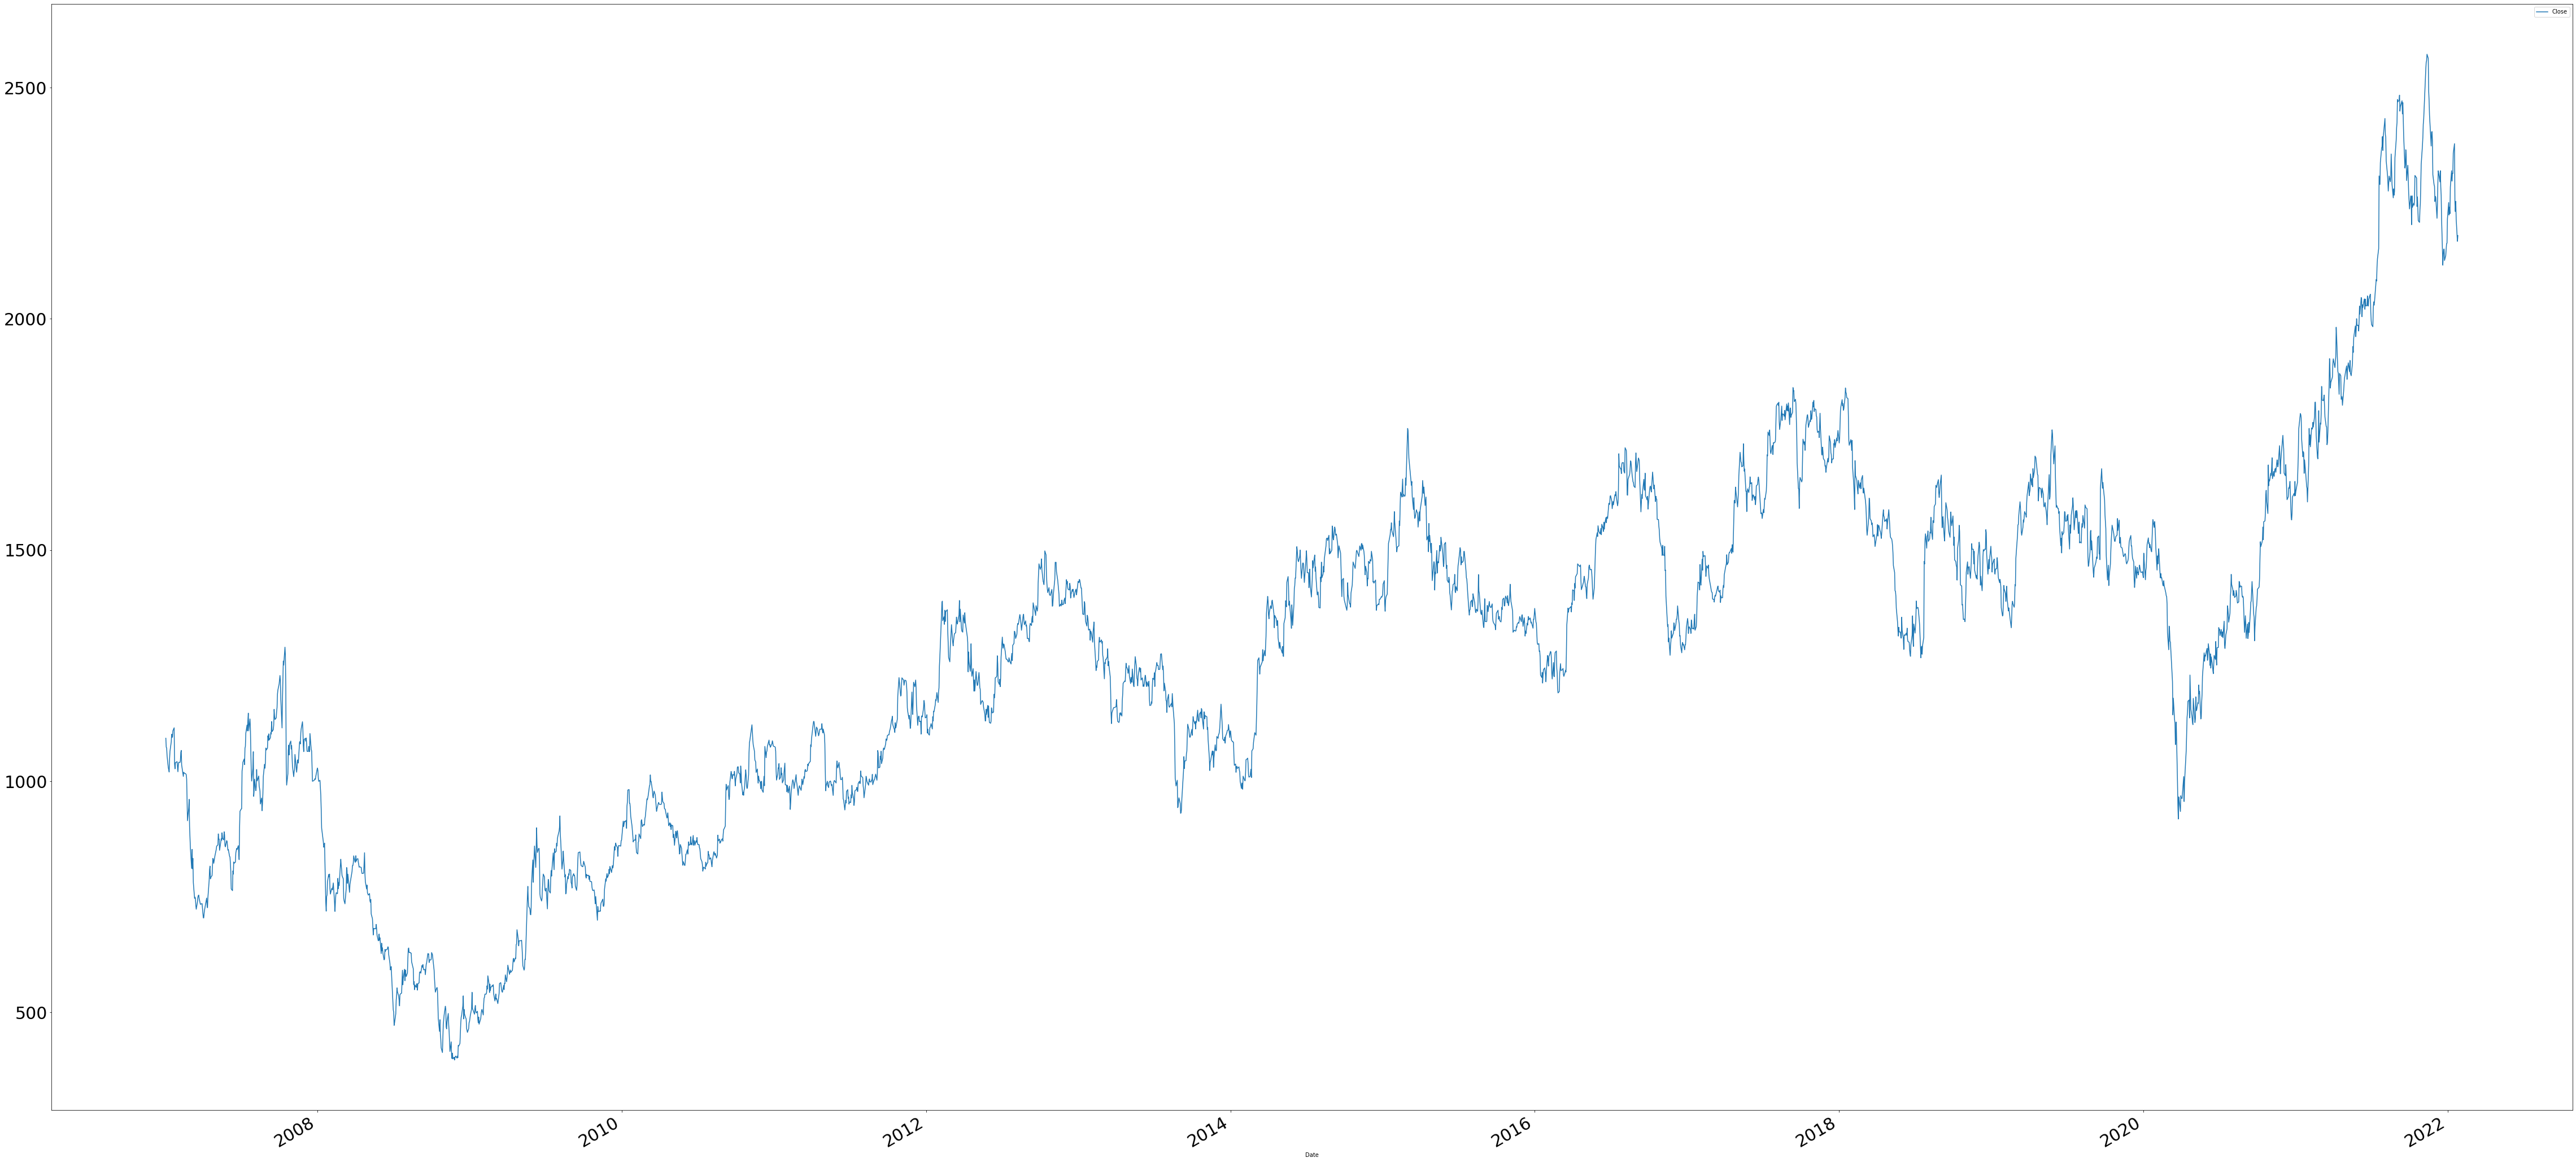

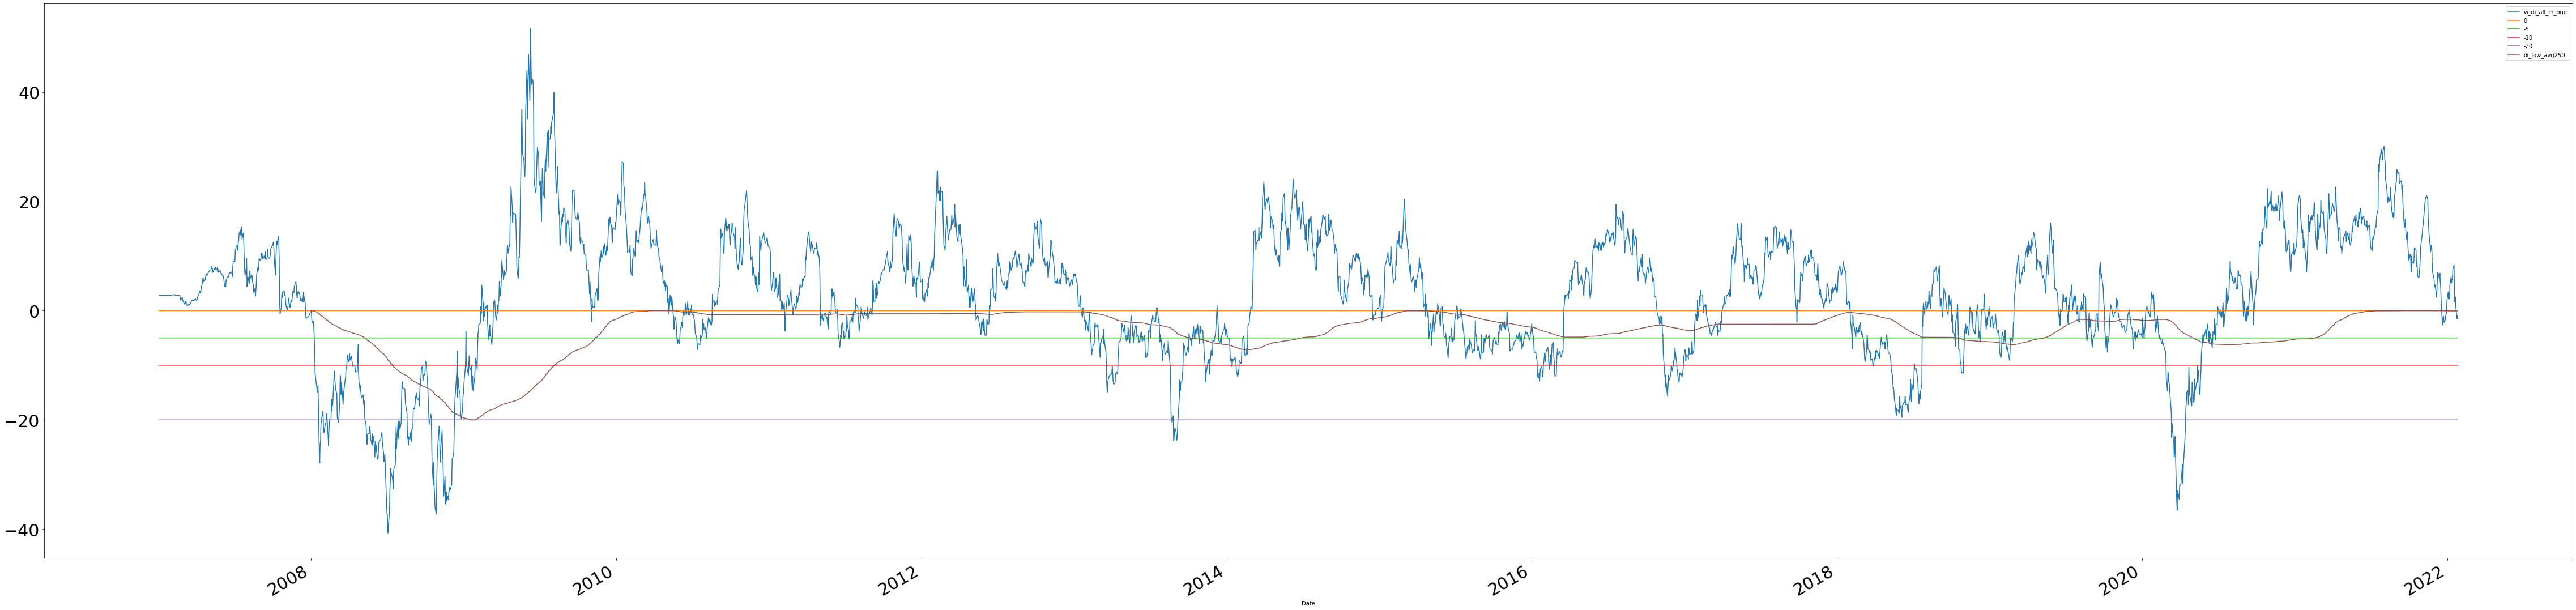

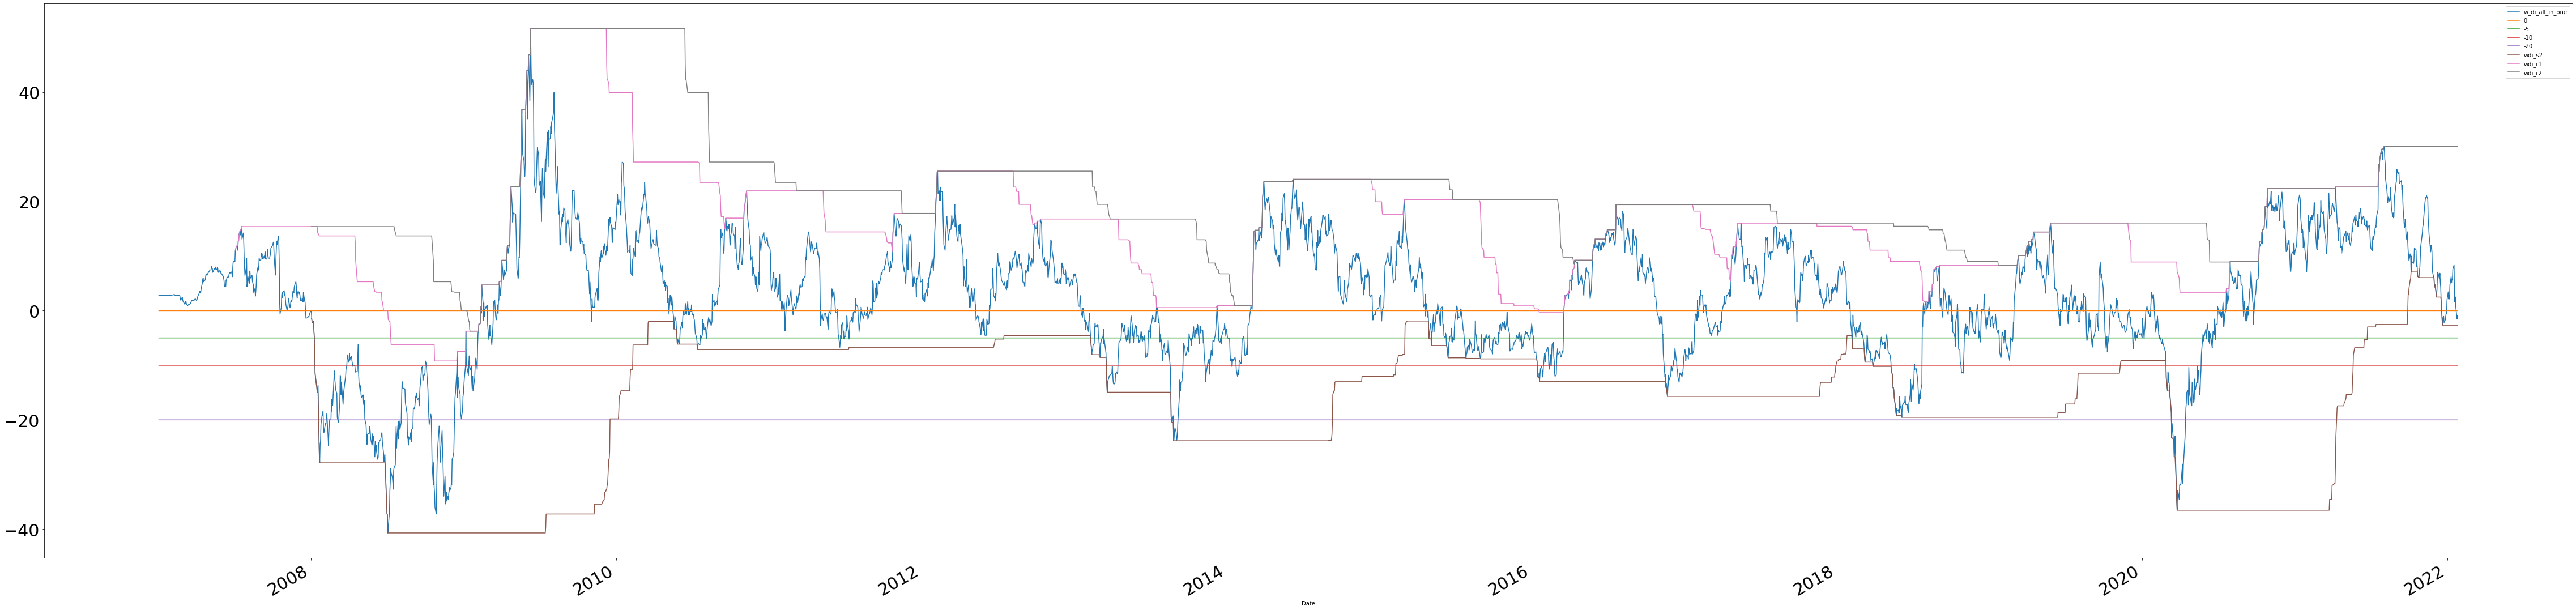

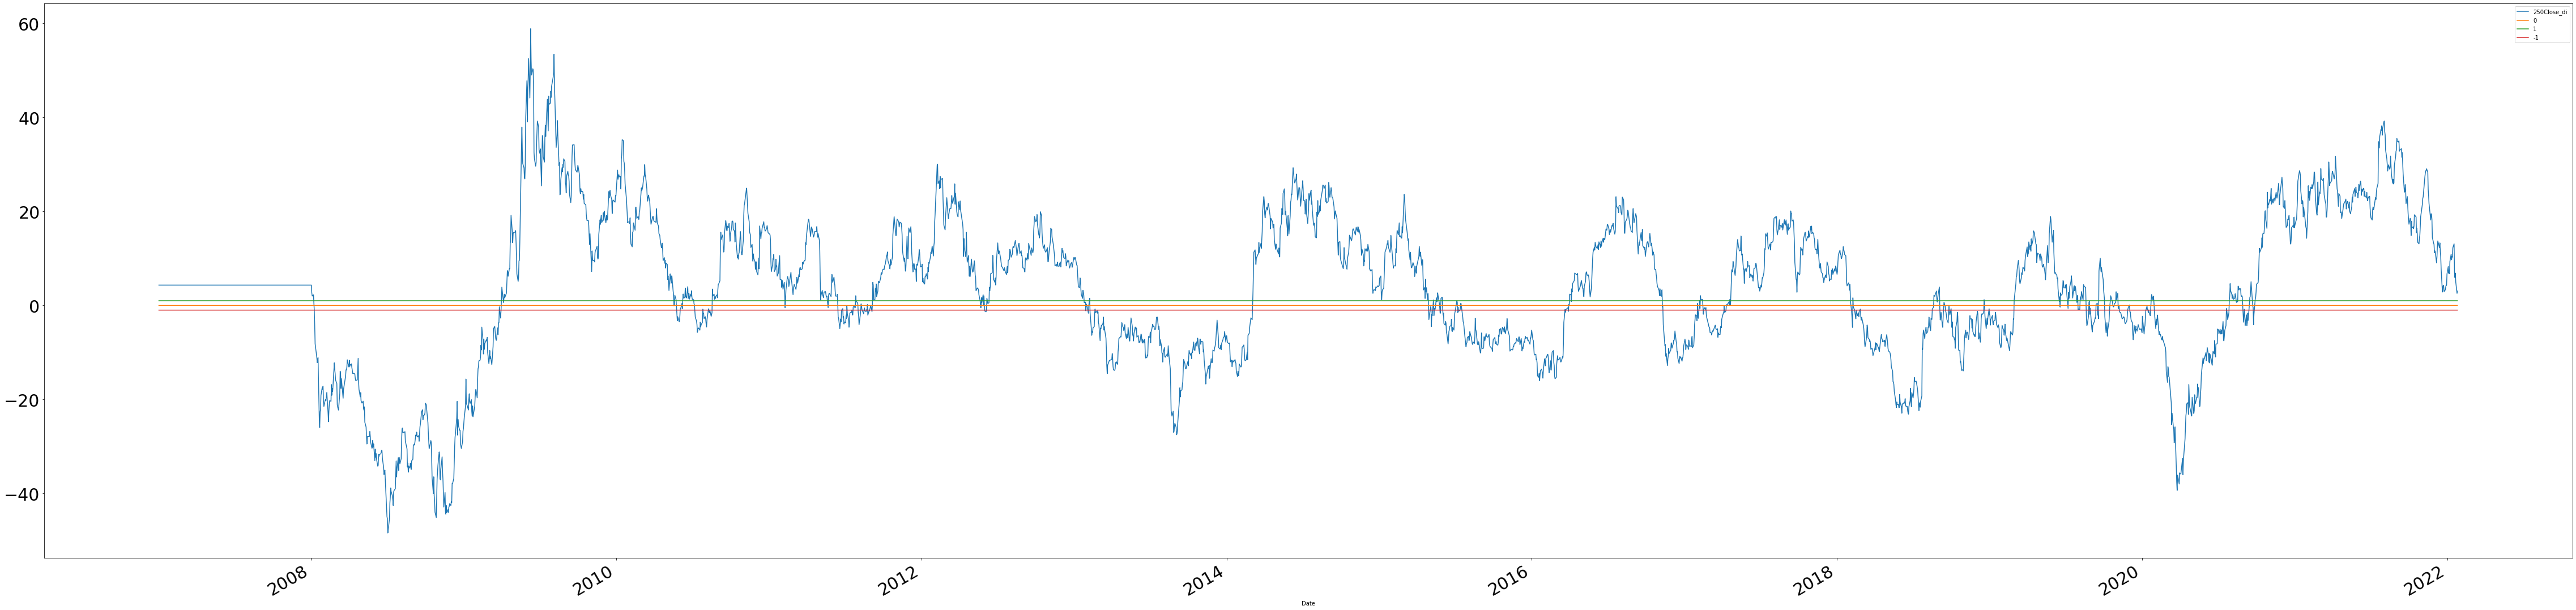

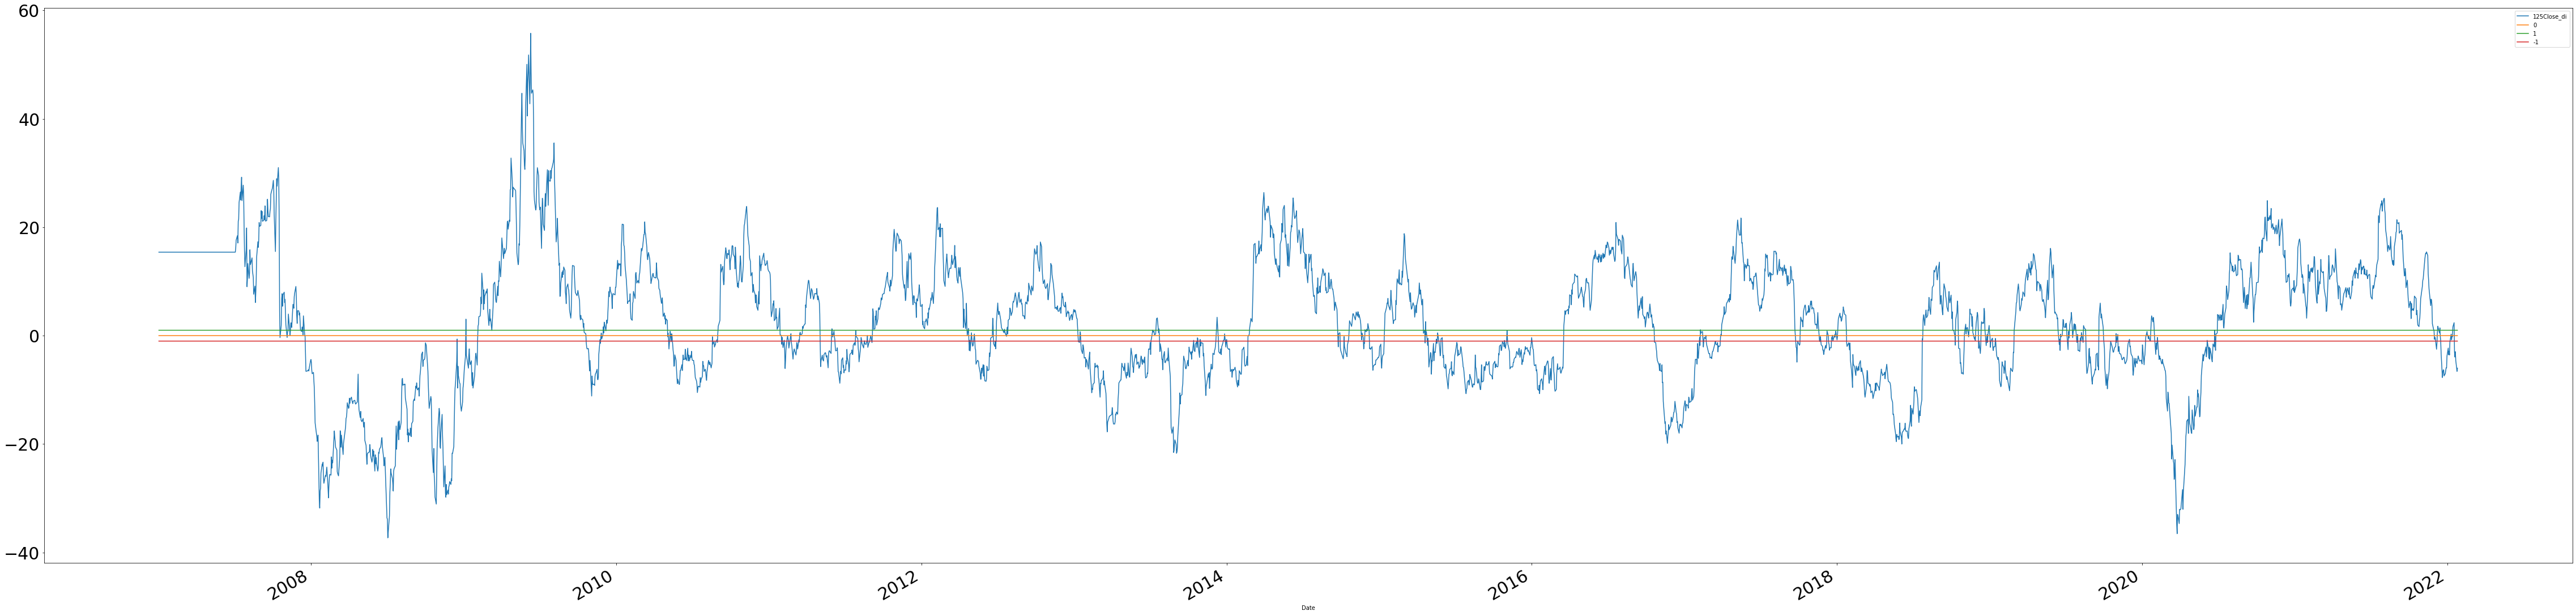

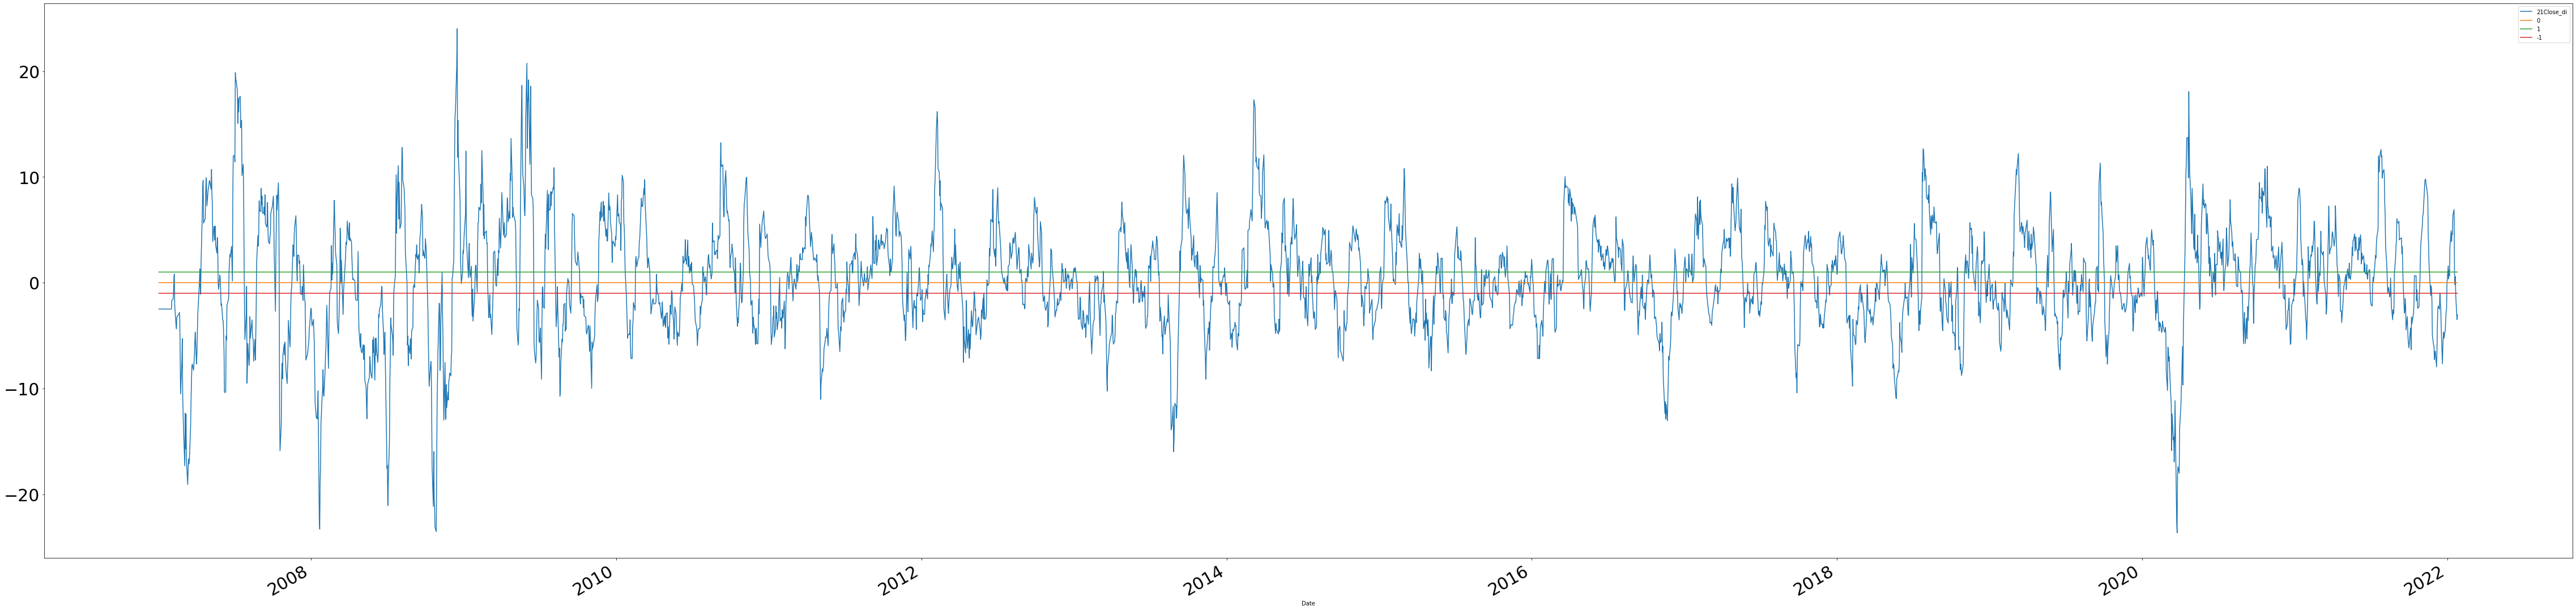

In [26]:
df[['Close']].plot(fontsize=30 ,figsize=(80,40))
df[['w_di_all_in_one','0','-5','-10','-20','di_low_avg250',]].plot(fontsize=30 ,figsize=(80,20))
df[['w_di_all_in_one','0','-5','-10','-20','wdi_s2','wdi_r1','wdi_r2']].plot(fontsize=30 ,figsize=(80,20))
# df[['5maStrengthop','0','1','-1','-5','-10','-20']].plot(fontsize=30 ,figsize=(80,20))
df[['250Close_di','0','1','-1']].plot(fontsize=30 ,figsize=(80,20))
df[['125Close_di','0','1','-1']].plot(fontsize=30 ,figsize=(80,20))
# df[['63Close_di','0','1','-1']].plot(fontsize=30 ,figsize=(80,20))
# df[['31Close_di','0','1','-1']].plot(fontsize=30 ,figsize=(80,20))
df[['21Close_di','0','1','-1']].plot(fontsize=30 ,figsize=(80,20))
# df[['250Close_di','125Close_di','63Close_di','21Close_di','0','1','-1']].plot(sharey =True,fontsize=30 ,figsize=(120,80))


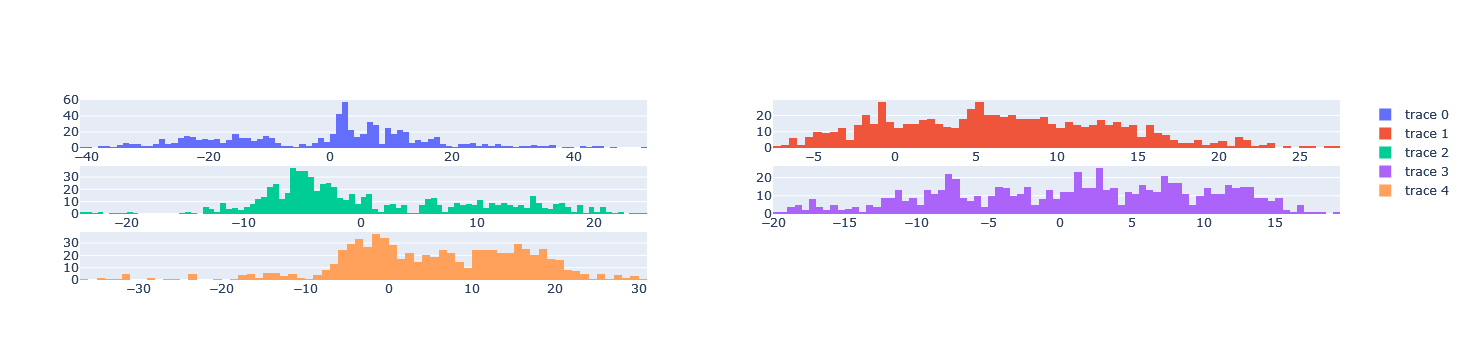

In [27]:
# df['w_di_all_in_one'].plot(kind='hist',bins=30,figsize=(30, 5),xticks=[-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,-2,-1,0,1,2,5,10,15,20,25,30,35,40,50,60,])
df79=df.loc[(df.index>'2007')&(df.index<'2010')]
df1012=df.loc[(df.index>'2010')&(df.index<'2013')]
df1315=df.loc[(df.index>'2013')&(df.index<'2016')]
df1618=df.loc[(df.index>'2016')&(df.index<'2019')]
df1921=df.loc[(df.index>'2019')&(df.index<'2022')]
fig = make_subplots(rows=3, cols=2)
trace0 = go.Histogram(x=df79['w_di_all_in_one'], nbinsx=100)
trace1 = go.Histogram(x=df1012['w_di_all_in_one'], nbinsx=100)
trace2 = go.Histogram(x=df1315['w_di_all_in_one'], nbinsx=100)
trace3 = go.Histogram(x=df1618['w_di_all_in_one'], nbinsx=100)
trace4 = go.Histogram(x=df1921['w_di_all_in_one'], nbinsx=100)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)
fig.append_trace(trace4, 3, 1)
fig.update()

fig.show()


In [28]:
bins=[-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,-2,-1,0,1,2,5,10,15,20,25,30,35,40,50,60,]
groups=df.groupby(pd.cut(df['w_di_all_in_one'],bins))
data=groups.Close.count()

<AxesSubplot:xlabel='w_di_all_in_one'>

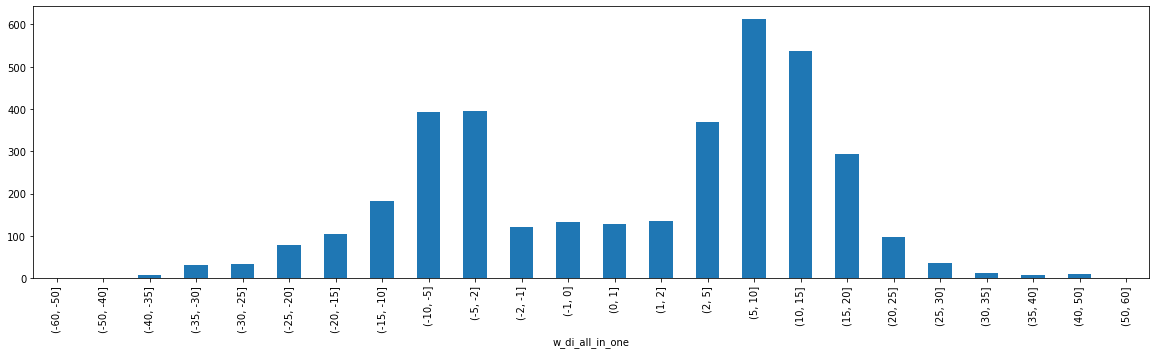

In [29]:
data
data.plot(kind='bar',figsize=(20, 5))

In [41]:
results={}
years=['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022',]
for year in range(len(years)):
    if year <len(years)-1:
        # nextyear=year+1
        df1=df.loc[(df.index>years[year])&(df.index<years[year+1])]
        bins=[-10,0,10,]
        groups=df1.groupby(pd.cut(df1['w_di_all_in_one'],bins))
        data=groups.Close.count()
        above0=data[1]
        below0=data[0]
        if not below0>1:
            below0=above0/2
        if above0>10:
            above0=10
        ratio=above0/below0
        results[years[year]]=ratio
        

In [42]:
results

{'2007': 1.4285714285714286,
 '2008': 0.0,
 '2009': 0.35714285714285715,
 '2010': 0.15873015873015872,
 '2011': 0.1388888888888889,
 '2012': 0.45454545454545453,
 '2013': 0.05405405405405406,
 '2014': 0.25,
 '2015': 0.06097560975609756,
 '2016': 0.18181818181818182,
 '2017': 0.19607843137254902,
 '2018': 0.08620689655172414,
 '2019': 0.078125,
 '2020': 0.1388888888888889,
 '2021': 1.1111111111111112}

In [44]:
resultdf=pd.DataFrame(results,index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [45]:
rdf=resultdf.T[[0]]

<AxesSubplot:>

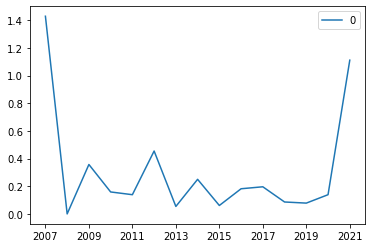

In [46]:
rdf.plot()

In [38]:
didf=df[['Close_di']]
didf['2']=2
didf['-2']=-2
didf['0']=0

KeyError: "None of [Index(['Close_di'], dtype='object')] are in the [columns]"

In [ ]:
df.loc[df.index>'2018-05-10']

In [ ]:
df.sort_values(by='wad_di')

In [ ]:
df['wad_di'].rank().plot(fontsize=30,figsize=(80,40))

In [ ]:

didf.plot(fontsize=30 ,figsize=(80,40))

In [ ]:
df[['Close','wad_di','wad','a/d','a/d_v']].plot(subplots=True,fontsize=30 ,figsize=(80,40))

In [ ]:
bins=[-10,-5,-4,-3,-2,0,2,3,4,5,10,]
groups=df.groupby(pd.cut(df.di,bins))
groups.Close.count()

In [ ]:
df.di.hist(bins=50,xlabelsize=30,ylabelsize=30,figsize=(80,8))

In [ ]:
def madisparity(df,ma,field):
    df['di']=(df[field]-df[field].rolling(ma).mean())/df[field].rolling(ma).mean()*100
    df.replace(to_replace=np.nan,method='bfill',inplace=True)
    return df

In [ ]:
df